In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [27]:
train_data=pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data=pd.read_csv('../data/kaggle_house_pred_test.csv')

In [28]:
print(train_data.iloc[0:3,[0,1,2,3,4]])

   Id  MSSubClass MSZoning  LotFrontage  LotArea
0   1          60       RL         65.0     8450
1   2          20       RL         80.0     9600
2   3          60       RL         68.0    11250


In [29]:
all_features=pd.concat([train_data.iloc[:,1:-1],test_data.iloc[:,1:]])

In [30]:
print(all_features)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1454         160       RM         21.0     1936   Pave   NaN      Reg   
1455         160       RM         21.0     1894   Pave   NaN      Reg   
1456          20       RL        160.0    20000   Pave   NaN      Reg   
1457          85       RL         62.0    10441   Pave   NaN      Reg   
1458          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...  

数据预处理，为了使所有特征在一个共同尺度，对特征进行标准化

In [31]:
numeric_features=all_features.dtypes[all_features.dtypes !='object'].index
all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/x.std())
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [32]:
all_features.shape

(2919, 79)

In [33]:
all_features[numeric_features].mean()

MSSubClass       8.641407e-17
LotFrontage      5.842078e-17
LotArea          2.921039e-17
OverallQual     -1.399665e-16
OverallCond      3.468734e-16
YearBuilt       -5.653428e-16
YearRemodAdd     6.815758e-16
MasVnrArea       5.355238e-17
BsmtFinSF1       2.312489e-17
BsmtFinSF2      -1.460519e-17
BsmtUnfSF        1.058877e-16
TotalBsmtSF     -8.519697e-18
1stFlrSF        -1.265784e-16
2ndFlrSF        -7.546017e-17
LowQualFinSF     6.328918e-17
GrLivArea        1.411836e-16
BsmtFullBath    -3.103604e-17
BsmtHalfBath    -1.947359e-17
FullBath         8.032857e-17
HalfBath         3.042749e-17
BedroomAbvGr     2.336831e-16
KitchenAbvGr    -5.574316e-16
TotRmsAbvGrd     2.434199e-16
Fireplaces       6.572338e-17
GarageYrBlt     -2.312489e-17
GarageCars       9.919362e-17
GarageArea      -6.754903e-17
WoodDeckSF      -4.990108e-17
OpenPorchSF     -2.312489e-17
EnclosedPorch    6.694048e-17
3SsnPorch       -2.677619e-17
ScreenPorch      4.138139e-17
PoolArea         6.085498e-18
MiscVal   

处理离散值，使用one-hot编码替换他们

In [34]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [35]:
data = pd.DataFrame({"学号":[1001,1002,1003,1004],
                    "性别":["男","女","女","男"],
                    "学历":["本科","硕士","专科","本科"]})
data

,学号,性别,学历
0,1001,男,本科
1,1002,女,硕士
2,1003,女,专科
3,1004,男,本科


In [36]:
print(pd.get_dummies(data,dummy_na=True))

     学号  性别_女  性别_男  性别_nan  学历_专科  学历_本科  学历_硕士  学历_nan
0  1001     0     1       0      0      1      0       0
1  1002     1     0       0      0      0      1       0
2  1003     1     0       0      1      0      0       0
3  1004     0     1       0      0      1      0       0


将数据转换为张量表示

In [39]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [40]:
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [42]:
train_data.SalePrice.values

array([208500, 181500, 223500, ..., 266500, 142125, 147500], dtype=int64)

In [59]:
loss=nn.MSELoss()
in_features=train_features.shape[1]

def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    return net

In [44]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

 clamp（）函数的功能将输入input张量每个元素的值压缩到区间 [min,max]，并返回结果到一个新张量。<br>
 ```torch.clamp(input, min, max, out=None) → Tensor```

In [62]:
from torch.utils.data import Dataset,DataLoader

class HousePrice(Dataset):
    def __init__(self,features,labels=None):
        self.features=features
        self.labels=labels
    
    def __getitem__(self,idx):
        if self.labels is None:
            return self.features[idx]
        else:
            return self.features[idx],self.labels[idx]
    
    def __len__(self):
        return len(self.features)
# train_dataset=HousePrice(train_features,train_labels)
# test_dataset=HousePrice(test_features)
# train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
# test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)

In [74]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    train_dataset=HousePrice(train_features,train_labels)
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
#     train_iter = d2l.load_array((train_features, train_labels), batch_size)
    for epoch in range(num_epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

k折交叉验证

In [75]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [76]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170001, 验证log rmse0.157033
折2，训练log rmse0.162520, 验证log rmse0.191932
折3，训练log rmse0.163628, 验证log rmse0.168204
折4，训练log rmse0.168333, 验证log rmse0.154698
折5，训练log rmse0.162754, 验证log rmse0.183015
5-折验证: 平均训练log rmse: 0.165447, 平均验证log rmse: 0.170977


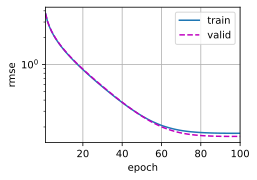

In [77]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [79]:
train_features.shape[0]

1460

In [80]:
1469 // 10

146

In [81]:
1460/10

146.0

In [91]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net=get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    pred=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(pred.reshape(1,-1)[0])
    print(pred.reshape(1,-1)[0])
    print(pd.Series(pred.reshape(1,-1)[0]))
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [92]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

[119687.18 153875.06 198664.11 ... 208175.   106921.69 240813.52]
0       119687.179688
1       153875.062500
2       198664.109375
3       217149.234375
4       177491.140625
            ...      
1454     74216.640625
1455     85489.343750
1456    208175.000000
1457    106921.687500
1458    240813.515625
Length: 1459, dtype: float32
